In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from scipy.ndimage import convolve
from skimage.morphology import disk

def gauss_ker(k, sig):
    x = np.linspace(-(k//2), (k//2), k)
    gx, gy = np.meshgrid(x, x)
    kernel = np.exp(-1*(gx**2 + gy**2)/(2*(sig**2)))
    return kernel

def normalize(array):
    """Min-Max Normalization of the array
    :param array: 2-D input image array
    :output : returns normalized arrays
    """
    #return (array - np.min(array))/(np.max(array)-np.min(array))
    return array/np.max(array)

def bilateral(filename,input_image, sigma_spatial, sigma_intensity):
    """
    Performs standard bilateral filtering of an input image. If padding is desired,
    img_in should be padded prior to calling

    inputs:- input_image       (ndarray) input image
           - sigma_spatial      (float)   spatial gaussian standard deviation
           - sigma_intensity      (float)   value gaussian standard. deviation
    outputs:-result      (ndarray) output bilateral-filtered image
    """
    # make a simple Gaussian function taking the squared radius
    gaussian = lambda r2, sigma: np.exp(-0.5*r2/sigma**2 )
    #print(input_image.shape)
    input_image = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)

    # define the window width to be the 2 time the spatial std. dev. to
    # be sure that most of the spatial kernel is actually captured
    win_width = int(2*sigma_spatial +1)
    wgt_sum = np.zeros_like(input_image).astype(np.float64)
    result  = np.zeros_like(input_image).astype(np.float64)
    out= np.zeros_like(input_image).astype(np.float64)

    for i in tqdm(range(input_image.shape[-1]),desc="Going through color channels"):
        norm_image = normalize(input_image[:,:,i])
        for shft_x in range(-win_width,win_width+1):
            for shft_y in range(-win_width,win_width+1):
                # compute the spatial contribution
                spatial = gaussian(shft_x**2+shft_y**2, sigma_spatial )

                # shift by the offsets to get image window
                window = np.roll(norm_image, [shft_y, shft_x], axis=[0,1])

                # compute the intensity contribution
                combined_filter = spatial*gaussian( (window-norm_image)**2, sigma_intensity )

                # result stores the mult. between combined filter and image window
                result[:,:,i] += window*combined_filter
                wgt_sum[:,:,i] += combined_filter
    out = normalize(result/wgt_sum)

    # normalize the result and return
    plt.imsave("outputImages/Bilateral_"+filename+"_"+str(sigma_spatial)+"_"+ str(sigma_intensity) + ".png" ,out)
    return out



def joint_bilateral(filename,flash_image,noflash_image,sigma_spatial,sigma_intensity):
    # make a simple Gaussian function taking the squared radius
    gaussian = lambda r2, sigma: np.exp(-0.5*r2/sigma**2)
    flash_image = cv2.cvtColor(flash_image,cv2.COLOR_BGR2RGB)
    noflash_image = cv2.cvtColor(noflash_image,cv2.COLOR_BGR2RGB)

    # define the window width to be the 2 time the spatial std. dev. to
    # be sure that most of the spatial kernel is actually captured
    win_width = int(2*sigma_spatial +1)
    wgt_sum = np.zeros_like(flash_image).astype(np.float64)
    result  = np.zeros_like(flash_image).astype(np.float64)
    out= np.zeros_like(flash_image).astype(np.float64)


    for i in tqdm(range(flash_image.shape[-1]),desc="Going through color channels"):
        norm_flash_image = normalize(flash_image[:,:,i])
        norm_noflash_image = normalize(noflash_image[:,:,i])
        for shft_x in range(-win_width,win_width+1):
            for shft_y in range(-win_width,win_width+1):
                # compute the spatial contribution
                spatial = gaussian(shft_x**2+shft_y**2, sigma_spatial )

                # shift by the offsets to get image window
                window = np.roll(norm_flash_image, [shft_y, shft_x], axis=[0,1])
                window_ambient = np.roll(norm_noflash_image, [shft_y, shft_x], axis=[0,1])
                # compute the intensity contribution
                combined_filter = spatial*gaussian((window-norm_flash_image)**2, sigma_intensity )

                # result stores the mult. between combined filter and image window
                result[:,:,i] += window_ambient*combined_filter
                wgt_sum[:,:,i] += combined_filter
    out = normalize(result/wgt_sum)
    # normalize the result and return
    plt.imsave("outputImages/JointBilateral_"+filename+"_"+str(sigma_spatial)+"_"+ str(sigma_intensity) + ".png" ,out)
    return out


def detail_transfer(name,flash_image,bilateral_flash, eps=0.02):
    # flash_bilateral = bilateral(name,flash_image,sigma_spatial,sigma_intensity)
    flash_image = cv2.cvtColor(flash_image.astype(np.float32),cv2.COLOR_BGR2RGB)
    detail = ((normalize(flash_image) + eps)/(bilateral_flash + eps))
    #avg_detail = (detail[:,:,0] + detail[:,:,1]+detail[:,:,2])/3
    #plt.imsave("outputImages/DetailLayer_"+name+"_" + str(sigma_spatial)+"_"+str(sigma_intensity)+".png")
    #plt.imsave("outputImages/DetailLayer"+name+".png",detail)
    plt.imshow(detail)
    #plt.imsave("outputImages/DetailLayer_"+name+"_" + str(sigma_spatial)+"_"+str(sigma_intensity)+".png",avg_detail,cmap="gray")

    return detail

def calculate_mask(name,flash_image,noflash_image):

    #luminance
    Y_flash = normalize(cv2.cvtColor(flash_image,cv2.COLOR_BGR2GRAY))
    Y_noflash = normalize(cv2.cvtColor(noflash_image,cv2.COLOR_BGR2GRAY))

    #shadow
    diff_image = Y_flash - Y_noflash
    shadow_mask = np.zeros(diff_image.shape, np.uint8)

    thr1 = -0.05
    thr2 = -0.2 
    shadow_mask[(diff_image > thr2) & (diff_image < thr1)] = 1
    shadow_mask[(diff_image > 0.65) & (diff_image < 0.7)] = 1

    #Specularity
    max_flash = 0.95 * (np.max(Y_flash) - np.min(Y_flash))
    # shadow_mask=np.zeros_like(diff_image)
    shadow_mask[Y_noflash>max_flash] = 1 
    plt.figure()
    plt.imshow(shadow_mask, cmap="gray")
    # dilation and erosion using circle elements
    se1 = disk(2)
    se2 = disk(6)
    se3 = disk(4)
    maskff = np.zeros((shadow_mask.shape[0]+2,shadow_mask.shape[1]+2), np.uint8)
    shadow_mask = cv2.erode(shadow_mask, se1, iterations = 1)
    cv2.floodFill(shadow_mask, maskff, (0,0), 1)
    maskff = cv2.dilate(maskff, se2,  iterations = 1)
    maskff = cv2.erode(maskff, se3, iterations = 1)
    maskff = maskff.astype('double')
    plt.figure()
    plt.imshow(maskff,cmap="gray")
    maskff = cv2.filter2D(maskff,-1, gauss_ker(3,3))

    plt.imsave("outputImages/CombinedMask_"+name+".png",maskff,cmap="gray")	
    return maskff


def flash_adjust(flash_image, noflash_image, alpha):

    flash_image = cv2.cvtColor(flash_image,cv2.COLOR_BGR2YCR_CB)
    noflash_image = cv2.cvtColor(noflash_image,cv2.COLOR_BGR2YCR_CB)

    adjust_img = np.zeros(noflash_image.shape).astype('double')
    adjust_img = alpha*noflash_image + (1-alpha)*flash_image

    adjust_img = adjust_img.astype(np.uint8)
    adjust_img = cv2.cvtColor(adjust_img, cv2.COLOR_YCR_CB2RGB)

    return adjust_img


def remove_noise(name, noflash_bilateral, f_detail, joint_b, mask):
    mask = mask[:-2,:-2]
    final = np.dstack(((1-mask), (1-mask), (1-mask)))*(joint_b*f_detail) + np.dstack((mask, mask, mask))*(noflash_bilateral)
    plt.figure()
    plt.imsave("outputImages/NoiseRemoved_"+name+".png",final)
    return final

In [18]:
flash_image = cv2.imread('flash_data_JBF_Detail_transfer/potsdetail_00_flash.tif')
noflash_image = cv2.imread('flash_data_JBF_Detail_transfer/potsdetail_01_noflash.tif')

name = "pots"
# mid_pix = (noflash_image.shape[0]//2-300,noflash_image.shape[1]//2-200)
# flash_image = flash_image[mid_pix[0]-200:mid_pix[0]+200,mid_pix[1]-200:mid_pix[1]+200,:]
# noflash_image = noflash_image[mid_pix[0]-200:mid_pix[0]+200,mid_pix[1]-200:mid_pix[1]+200,:]

bilateral_flash = bilateral(name,flash_image,3,0.06)
bilateral_noflash = bilateral(name,noflash_image,3,0.06)
joint_bilateral_out = joint_bilateral(name, flash_image, noflash_image,3, 0.06)

Going through color channels: 100%|██████████| 3/3 [02:22<00:00, 47.52s/it]


In [3]:
#joint_bilateral_out = joint_bilateral("out3", flash_image, noflash_image, 3, 0.75)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


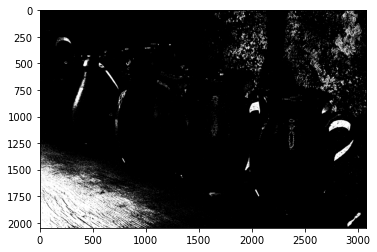

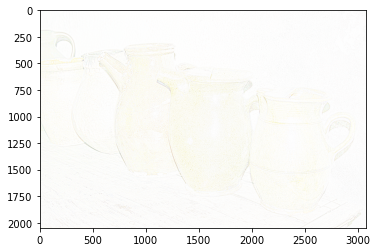

In [26]:
# flash_image = cv2.imread('flash_data_JBF_Detail_transfer/potsdetail_00_flash.tif')
mask = calculate_mask(name, flash_image, noflash_image)
f_detail = detail_transfer(name,flash_image,bilateral_flash,0.02)

In [22]:
final = remove_noise(name, bilateral_noflash, f_detail, joint_bilateral_out, mask)

<Figure size 432x288 with 0 Axes>

In [27]:
without_mask = f_detail*joint_bilateral_out
plt.imsave("outputImages/Without_Mask_"+name+".png",normalize(without_mask))